In [1]:
!pip install transformers
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import torch
import torch.nn as nn
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [3]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import transformers
import json
# from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
# from transformers import RobertaModel, RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import RobertaModel, AdamW
from transformers import get_linear_schedule_with_warmup
from transformers.optimization import AdamW
from sys import platform
import os
import logging
logging.basicConfig(level=logging.ERROR)

In [4]:
from transformers import (
    BertForSequenceClassification, 
    AlbertForSequenceClassification, 
    XLNetForSequenceClassification, 
    RobertaForSequenceClassification, 
    AutoTokenizer
)

In [5]:
max_seq_len = 40

In [7]:
class RobertModel(nn.Module):
    def __init__(self, requires_grad = True):
        super(RobertModel, self).__init__()
        # config = RobertaForSequenceClassification.from_pretrained( 'roberta-base', output_hidden_states=True, num_labels = 2)    
        # self.bert = RobertaForSequenceClassification.from_pretrained(bert_model, output_hidden_states=True, num_labels = 2)
        # self.tokenizer = AutoTokenizer.from_pretrained(bert_model, do_lower_case=True)
        self.bert = torch.load('../FND/Model/output/Roberta/Roberta-base/model-roberta-base.pth')
        self.tokenizer = torch.load('../FND/Model/output/Roberta/Roberta-base/tokenizer-roberta-base.pth')
        self.requires_grad = requires_grad
        self.device = torch.device("cuda")
        for param in self.bert.parameters():
            param.requires_grad = requires_grad  # Each parameter requires gradient

    def forward(self, batch_seqs, batch_seq_masks, batch_seq_segments, labels = None):

        loss, logits = self.bert(input_ids = batch_seqs, attention_mask = batch_seq_masks, 
                                  token_type_ids=batch_seq_segments, labels = labels)[:2]
        # print(logits)
        probabilities = nn.functional.softmax(logits, dim=-1)
        # print(probabilities)
        return loss, logits, probabilities

In [8]:
import time
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report
)  

In [9]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

In [31]:
PATH = 'Model/roberta-fng-d.pth'

model = RobertModel(requires_grad = True)
checkpoint = torch.load(PATH)
# model.to(device)
model.load_state_dict(checkpoint['model'])
model = model.eval()

In [32]:
for i in checkpoint:
    print(i)

epoch
model
optimizer
tokenizer
best_score
epochs_count
train_losses
train_accuracy
valid_losses
valid_accuracy
valid_auc
epoch_times


In [33]:
checkpoint['epoch_times'],checkpoint['train_losses'],checkpoint['train_accuracy'],checkpoint['valid_losses'],checkpoint['valid_accuracy']

([183.3703064918518, 183.68939113616943, 183.57533478736877],
 [0.6929742412096789,
  0.35232970566428257,
  0.12376934681628567,
  0.08844500306425337],
 [0.49104859335038364,
  0.8224171005755001,
  0.9562893943546177,
  0.9702658262537681],
 [0.6929742412096789,
  0.15351137345289292,
  0.1266853003604274,
  0.1309729260608291],
 [0.49104859335038364,
  0.9441602728047741,
  0.960997442455243,
  0.9631287297527706])

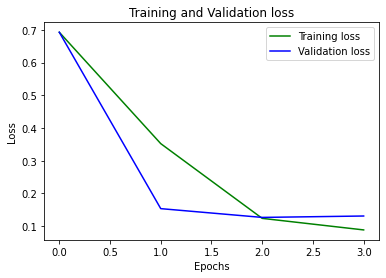

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

loss_train = checkpoint['train_losses']
loss_val = checkpoint['valid_losses']
# epochs = checkpoint['epochs_count']
epochs = [0,1,2,3]
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

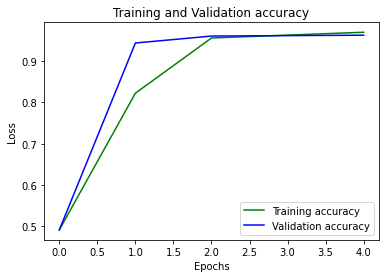

In [37]:
# !pip install matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

loss_train = checkpoint['train_accuracy']
loss_val = checkpoint['valid_accuracy']
# epochs = checkpoint['epochs_count']
epochs = [0,1,2,4]
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
tokenizer = model.tokenizer
# tokenizer1 = model1.tokenizer

In [20]:
news = "Capitol riot hearing: Trump dismisses daughter Ivanka's testimony'"

In [21]:
test = len(news.split())
if test <= 512:
    max_len = test
else:
    max_len = 512
test

8

In [23]:
encoding = tokenizer(news, 
                     pad_to_max_length=True,
                     truncation=True,
                     max_length= max_len ,
                     return_tensors='pt',
                     return_token_type_ids= True)

In [24]:
for i in encoding:
    print(i)

input_ids
token_type_ids
attention_mask


In [25]:

input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']
token_type_ids = encoding['token_type_ids']
labels = torch.tensor([1])


In [29]:
model1 = model1.to(device)
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
token_type_ids = encoding['token_type_ids'].to(device)
labels = torch.tensor([1]).to(device)

In [26]:
news

"Capitol riot hearing: Trump dismisses daughter Ivanka's testimony'"

In [28]:
loss, logits, probabilities = model(input_ids,attention_mask,token_type_ids, labels=labels)

In [29]:
fake_prob = probabilities[0][0].item()
real_prob = probabilities[0][1].item()
if real_prob >= 0.5:
    print('This article is: Real')
else:
    print('This article is: Fake')

This article is: Real


In [ ]:
probabilities

tensor([[0.0093, 0.9907]], grad_fn=<SoftmaxBackward0>)